<a href="https://colab.research.google.com/github/connor-lavine/ORFE-Senior-Thesis/blob/main/ORF499_SpringInterimReportCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I acknowledge the assistance of ChatGPT to help prepare this ipynb file.

# Imports

In [1]:
_ = !pip install hmmlearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from hmmlearn.hmm import GaussianHMM

from IPython.display import display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:,.2f}'.format)

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Loading Data

In [3]:
# Collected from OpusData free academic extract samples

# Function to standardize column names
def clean_cols(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
        .str.lower()
    )
    return df

# Core movie summaries
movie_basic = clean_cols(pd.read_csv('./MovieData.csv'))
movie_summary = clean_cols(pd.read_csv('./movie_summary.csv'))

# Box office
daily_boxoffice = clean_cols(pd.read_csv('./daily_boxoffice.csv'))
weekly_boxoffice = clean_cols(pd.read_csv('./weekly_boxoffice.csv'))
weekend_boxoffice = clean_cols(pd.read_csv('./weekend_boxoffice.csv'))
weekend_international = clean_cols(pd.read_csv('./weekend_international.csv'))
international_financials = clean_cols(
    pd.read_csv('./international_financials.csv')
)

# Video / home entertainment
movie_video_summary = clean_cols(pd.read_csv('./movie_video_summary.csv'))
movie_video_releases = clean_cols(pd.read_csv('./movie_video_releases.csv'))
movie_weekly_vod = clean_cols(pd.read_csv('./movie_weekly_vod.csv'))
movie_weekly_dvd = clean_cols(pd.read_csv('./movie_weekly_dvd.csv'))
movie_weekly_bluray = clean_cols(pd.read_csv('./movie_weekly_bluray.csv'))
movie_weekly_physical_disc_rental = clean_cols(
    pd.read_csv('./movie_weekly_physical_disc_rental.csv')
)

# Credits / people
acting_credits = clean_cols(pd.read_csv('./acting_credits.csv'))
technical_credits = clean_cols(pd.read_csv('./technical_credits.csv'))
people = clean_cols(pd.read_csv('./people.csv'))

# Production context
production_companies = clean_cols(pd.read_csv('./production_companies.csv'))
production_countries = clean_cols(pd.read_csv('./production_countries.csv'))
movie_languages = clean_cols(pd.read_csv('./movie_languages.csv'))
movie_keywords = clean_cols(pd.read_csv('./movie_keywords.csv'))
movie_franchises = clean_cols(pd.read_csv('./movie_franchises.csv'))
movie_ratings = clean_cols(pd.read_csv('./movie_ratings.csv'))
movie_releases = clean_cols(pd.read_csv('./movie_releases.csv'))

# Website identifiers
movie_identifiers = clean_cols(pd.read_csv('./movie_identifiers.csv'))

# Data Pre-Processing

In [4]:
# Master table for movies using movie_odid
movie_master = movie_basic.copy()

# Add in rows from 50 blockbuster sample
blockbuster_info = movie_summary[
    ['display_name',
    'production_year',
    'movie_odid',
    'production_budget',
    'domestic_box_office',
    'international_box_office',
    'creative_type',
    'source',
    'production_method',
    'genre',
    'sequel',
    'running_time',]
]
blockbuster_info = blockbuster_info.rename(
    columns={'display_name': 'movie_name'}
)
blockbuster_info = blockbuster_info.merge(
    movie_ratings[['movie_odid', 'rating']], on='movie_odid', how='left'
)
movie_master = pd.concat([movie_master, blockbuster_info], ignore_index=True)

# Ensure that numbers are converted to numerics
for col in [
    'production_year',
    'production_budget',
    'domestic_box_office',
    'international_box_office',
    'sequel',
    'running_time',
]:
    movie_master[col] = pd.to_numeric(movie_master[col], errors='coerce')

# Drop films with missing/zero budget
movie_master = movie_master[movie_master['production_budget'] > 0]

# Calculate the worldwide box office as the sum of domestic and international
movie_master['worldwide_box_office'] = (
    movie_master['domestic_box_office'].fillna(0)
    + movie_master['international_box_office'].fillna(0)
)

# Calculate the log of box office and budget
for col in [
    'domestic_box_office',
    'international_box_office',
    'worldwide_box_office',
    'production_budget',
]:
    movie_master[f'log_{col}'] = np.log1p(movie_master[col])

# Calculate return on investment based on box office and budget
for loc in {'domestic', 'international', 'worldwide'}:
    movie_master[f'roi_{loc}'] = (
        movie_master[f'{loc}_box_office'] / movie_master['production_budget']
    )

# Success indicator: did worldwide box office at least double production budget?
movie_master['success_indicator'] = (
    (movie_master['worldwide_box_office'] >= (
        2 * movie_master['production_budget'])
    )
)

# Sort master data by ID
movie_master = movie_master.sort_values('movie_odid')

In [5]:
# Weekly box office data for 50 blockbuster sample
weekly_data = weekly_boxoffice.copy()

# Ensure that dates are converted to datetimes
weekly_data['chart_date'] = pd.to_datetime(weekly_data['chart_date'], errors='coerce')

# Ensure that numbers are converted to numerics
for col in [
    'revenue', 'revenue_estimated', 'tickets', 'theaters',
    'total_revenue', 'total_tickets', 'days_in_release'
]:
    weekly_data[col] = pd.to_numeric(weekly_data[col], errors='coerce')

# Sort chronologically (do NOT sort by days_in_release)
weekly_data = weekly_data.sort_values(['movie_odid', 'chart_date'])

# Keep week_index for backward compatibility
weekly_data['week_index'] = weekly_data.groupby('movie_odid').cumcount() + 1

# Detect re-release "spells"
weekly_data['gap_days'] = weekly_data.groupby('movie_odid')['chart_date'].diff().dt.days
weekly_data['days_reset'] = weekly_data.groupby('movie_odid')['days_in_release'].diff()

weekly_data['new_spell'] = (
    weekly_data['gap_days'].isna() |
    (weekly_data['gap_days'] > 21) |
    (weekly_data['days_reset'] < 0)
)

weekly_data['spell_id'] = weekly_data.groupby('movie_odid')['new_spell'].cumsum().astype(int)
weekly_data['week_in_spell'] = weekly_data.groupby(['movie_odid', 'spell_id']).cumcount() + 1

# Core transforms
weekly_data['log_revenue'] = np.log1p(weekly_data['revenue'])
weekly_data['rev_per_theater'] = weekly_data['revenue'] / weekly_data['theaters']
weekly_data['rev_per_theater'] = weekly_data['rev_per_theater'].replace([np.inf, -np.inf], np.nan)
weekly_data['log_rev_per_theater'] = np.log1p(weekly_data['rev_per_theater'])

# Movie IDs
movie_ids = weekly_data['movie_odid'].unique()

In [6]:
# --- Seasonality features (week-of-year) ---
weekly_data['week_of_year'] = weekly_data['chart_date'].dt.isocalendar().week.astype(int)
weekly_data.loc[weekly_data['week_of_year'] == 53, 'week_of_year'] = 52  # map ISO week 53 -> 52

weekly_data['woy_sin'] = np.sin(2*np.pi*weekly_data['week_of_year']/52.0)
weekly_data['woy_cos'] = np.cos(2*np.pi*weekly_data['week_of_year']/52.0)

# --- Additional logs (safe; won’t affect downstream code) ---
weekly_data['log_theaters'] = np.log1p(weekly_data['theaters'])

# rev_per_theater already exists in your cell 7; this just makes it robust
weekly_data['rev_per_theater'] = weekly_data['revenue'] / weekly_data['theaters']
weekly_data['rev_per_theater'] = weekly_data['rev_per_theater'].replace([np.inf, -np.inf], np.nan)
weekly_data['log_rev_per_theater'] = np.log1p(weekly_data['rev_per_theater'])

# --- Deseasonalization helper (pooled across all film-weeks) ---
def add_deseasonalized(df, y_col, out_col):
    """
    Fits: y = b0 + b1*sin + b2*cos + eps  (pooled)
    Stores residuals eps in out_col.
    """
    mask = df[[y_col, 'woy_sin', 'woy_cos']].notna().all(axis=1)
    X = np.column_stack([
        np.ones(mask.sum()),
        df.loc[mask, 'woy_sin'].to_numpy(),
        df.loc[mask, 'woy_cos'].to_numpy(),
    ])
    y = df.loc[mask, y_col].to_numpy()

    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    fitted = X @ beta

    df[out_col] = np.nan
    df.loc[mask, out_col] = y - fitted
    return beta

beta_logrev = add_deseasonalized(weekly_data, 'log_revenue', 'log_revenue_deseason')
beta_logrpt = add_deseasonalized(weekly_data, 'log_rev_per_theater', 'log_rpt_deseason')

print("Deseason beta (log_revenue):", beta_logrev)
print("Deseason beta (log_rev_per_theater):", beta_logrpt)

Deseason beta (log_revenue): [14.30332096  0.03904679 -0.57148285]
Deseason beta (log_rev_per_theater): [ 7.86181766  0.07247434 -0.29223659]


# HMM Sample (using 50 blockbuster movies)

In [7]:
# Subset of master list for films that have weekly box office data
movie_master_50 = movie_master[movie_master['movie_odid'].isin(movie_ids)]

# Total number of weeks in box office (per movie)
weeks_per_movie = (
    weekly_data.groupby('movie_odid')['week_index'].max()
    .rename('weeks_in_release')
)
movie_master_50 = movie_master_50.merge(
    weeks_per_movie, on='movie_odid', how='left'
)

# Full sample of weekly data to use for HMM
weekly_hmm = weekly_data.merge(
    movie_master_50,
    on='movie_odid',
    how='inner',
)

# Ensure that HMM sample is cleaned
weekly_hmm = weekly_hmm[
    weekly_hmm['revenue'].notna()
    & weekly_hmm['theaters'].notna()
    & (weekly_hmm['theaters'] > 0)
]

In [8]:
def _smooth_one_week_blips(arr):
    arr = arr.copy()
    if len(arr) < 3:
        return arr
    for i in range(1, len(arr) - 1):
        if arr[i-1] == arr[i+1] and arr[i] != arr[i-1]:
            arr[i] = arr[i-1]
    return arr

def fit_hmm_states(
    df,
    obs_col,
    group_cols=("movie_odid","spell_id"),
    sort_col="week_in_spell",
    K=6,
    sticky=0.97,
    n_iter=500,
    random_state=0,
    smooth_blips=False
):
    """
    Fits a sticky Gaussian HMM on df[obs_col] with sequence boundaries defined by group_cols.
    Returns:
      d: df subset (non-missing obs_col) with a ranked 'state' column (0=lowest mean ... K-1=highest mean)
      model: fitted hmmlearn model
      means_sorted: state means in low->high order
    """
    d = df.copy()

    # robust sort column
    if sort_col not in d.columns:
        sort_col = "week_index"

    d = d.sort_values(list(group_cols) + [sort_col]).copy()
    d = d[d[obs_col].notna()].copy()

    X = d[[obs_col]].to_numpy()
    lengths = d.groupby(list(group_cols))[obs_col].size().tolist()

    model = GaussianHMM(
        n_components=K,
        covariance_type="diag",
        n_iter=n_iter,
        random_state=random_state,
        min_covar=1e-3
    )
    model.startprob_ = np.full(K, 1.0 / K)
    trans = np.full((K, K), (1 - sticky) / (K - 1))
    np.fill_diagonal(trans, sticky)
    model.transmat_ = trans

    model.init_params = "mc"
    model.params = "stmc"
    model.fit(X, lengths)

    raw = model.predict(X, lengths)

    means_raw = model.means_.reshape(-1)
    order = np.argsort(means_raw)   # low->high
    inv = np.empty_like(order)
    inv[order] = np.arange(K)
    ranked = inv[raw]

    d["state"] = ranked

    if smooth_blips:
        def _apply(g):
            g = g.sort_values(sort_col)
            g["state"] = _smooth_one_week_blips(g["state"].to_numpy())
            return g
        d = d.groupby(list(group_cols), group_keys=False).apply(_apply)

    means_sorted = means_raw[order]
    return d, model, means_sorted


# -------- Fit two deseasonalized models for visualization --------
OBS_REVENUE = "log_revenue_deseason"
OBS_DEMAND  = "log_rpt_deseason"

for c in [OBS_REVENUE, OBS_DEMAND, "week_in_spell", "spell_id"]:
    if c not in weekly_hmm.columns:
        raise ValueError(f"Missing {c} in weekly_hmm. Make sure preprocessing + seasonality cells ran.")

GROUP_COLS = ("movie_odid","spell_id")
K_REV = 6
K_RPT = 6

rev_df, rev_model, rev_means = fit_hmm_states(
    weekly_hmm, OBS_REVENUE, group_cols=GROUP_COLS, sort_col="week_in_spell",
    K=K_REV, sticky=0.97, random_state=9, smooth_blips=False
)
rpt_df, rpt_model, rpt_means = fit_hmm_states(
    weekly_hmm, OBS_DEMAND, group_cols=GROUP_COLS, sort_col="week_in_spell",
    K=K_RPT, sticky=0.97, random_state=9, smooth_blips=False
)

hmm_compare_df = weekly_hmm.copy()
hmm_compare_df = hmm_compare_df.merge(
    rev_df[list(GROUP_COLS)+["week_index","state"]].rename(columns={"state":"state_rev_deseason"}),
    on=list(GROUP_COLS)+["week_index"],
    how="left"
)
hmm_compare_df = hmm_compare_df.merge(
    rpt_df[list(GROUP_COLS)+["week_index","state"]].rename(columns={"state":"state_rpt_deseason"}),
    on=list(GROUP_COLS)+["week_index"],
    how="left"
)

print("Revenue-deseason HMM means (low->high):", rev_means)
print("Rev/theater-deseason HMM means (low->high):", rpt_means)
print("Created hmm_compare_df with: state_rev_deseason, state_rpt_deseason")


Revenue-deseason HMM means (low->high): [-3.74984911 -2.01672009 -0.89889754  0.31055955  1.47381878  3.04422526]
Rev/theater-deseason HMM means (low->high): [-1.24510184 -0.59164749 -0.0954896   0.45287125  1.10395721  1.96010624]
Created hmm_compare_df with: state_rev_deseason, state_rpt_deseason


# Data Summary Statistics

In [9]:
# Print descriptive statistics of all 2,276 movies
summary_movie_master = movie_master[
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide']
].describe(percentiles=[0.25, 0.5, 0.75])

# Print descriptive statistics of original metadata by excluding 50 blockbusters
summary_movie_basic = movie_master[
    movie_master['movie_odid'].isin(movie_basic['movie_odid'])
    ][
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide']
].describe(percentiles=[0.25, 0.5, 0.75])

# Descriptive statistics about 50 blockbuster movies
summary_movie_50 = movie_master_50[
    ['production_budget',
     'domestic_box_office',
     'international_box_office',
     'worldwide_box_office',
     'roi_worldwide',
     'weeks_in_release',]
].describe(percentiles=[0.25, 0.5, 0.75])
genre_counts_50 = movie_master_50['genre'].value_counts(dropna=False)
sequel_counts_50 = movie_master_50['sequel'].value_counts(dropna=False)
rating_counts_50 = movie_master_50['rating'].value_counts(dropna=False)

# Number of weeks in theaters
weeks_summary = weeks_per_movie.describe()

# Weekly revenue
revenue_summary = weekly_hmm['revenue'].describe(percentiles=[0.25, 0.5, 0.75])

# Theaters per week
theaters_summary = weekly_hmm['theaters'].describe(percentiles=[0.25, 0.5, 0.75])

# Print summary statistics
print('Statistics for movie_master:')
display(summary_movie_master)
print('Statistics for movie_basic:')
display(summary_movie_basic)
print('Statistics for 50 blockbuster movies:')
display(summary_movie_50)
print('\nStatistics for number of weeks in theaters:')
display(weeks_summary)
print('\nStatistics for genre:')
display(genre_counts_50)
print('\nStatistics for sequel status:')
display(sequel_counts_50)
print('\nStatistics for ratings:')
display(rating_counts_50)
print('\nStatistics for weekly revenue:')
display(revenue_summary)
print('\nStatistics for theaters per week:')
display(theaters_summary)

Statistics for movie_master:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide
count,"2,276.00","2,276.00","2,276.00","2,276.00","2,276.00"
mean,"46,039,226.75","60,091,453.38","90,521,282.60","150,612,735.98",4.00
std,"60,099,937.37","103,685,670.31","177,046,162.90","271,009,025.60",11.65
min,"9,000.00",0.00,0.00,17.00,0.00
25%,"7,500,000.00","1,746,632.25","1,998,604.25","7,309,969.25",0.71
50%,"20,755,827.00","20,536,095.00","19,141,459.00","42,429,088.00",2.06
75%,"60,000,000.00","65,212,928.75","86,308,120.00","155,573,965.50",4.21
max,"533,200,000.00","936,662,225.00","1,977,903,876.00","2,717,503,922.00",429.64


Statistics for movie_basic:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide
count,"2,226.00","2,226.00","2,226.00","2,226.00","2,226.00"
mean,"44,445,184.23","53,786,828.53","82,644,641.53","136,431,470.06",3.81
std,"58,879,158.24","95,047,643.11","167,541,732.36","253,212,293.13",11.51
min,"9,000.00",0.00,0.00,17.00,0.00
25%,"7,000,000.00","1,518,675.75","1,900,765.50","7,007,252.00",0.68
50%,"20,000,000.00","19,414,060.00","17,552,748.50","40,700,036.00",1.97
75%,"55,000,000.00","60,697,323.25","77,198,752.00","138,977,671.00",4.06
max,"533,200,000.00","936,662,225.00","1,977,903,876.00","2,717,503,922.00",429.64


Statistics for 50 blockbuster movies:


,production_budget,domestic_box_office,international_box_office,worldwide_box_office,roi_worldwide,weeks_in_release
count,50.00,50.00,50.00,50.00,50.00,50.00
mean,"117,006,000.00","340,773,351.68","441,189,343.14","781,962,694.82",12.05,29.46
std,"70,898,718.82","82,005,062.70","228,923,033.14","287,581,863.92",14.66,14.58
min,"10,500,000.00","252,651,617.00","85,096,578.00","347,522,208.00",2.76,7.00
25%,"60,750,000.00","290,398,924.75","281,350,720.50","594,727,921.75",4.68,21.25
50%,"115,000,000.00","316,783,061.00","431,618,222.00","791,261,770.00",7.54,23.00
75%,"157,750,000.00","380,464,671.75","563,041,071.25","925,296,817.50",12.26,34.50
max,"300,000,000.00","674,460,013.00","1,548,588,773.00","2,223,048,786.00",75.93,71.00



Statistics for number of weeks in theaters:


,weeks_in_release
count,50.00
mean,29.46
std,14.58
min,7.00
25%,21.25
50%,23.00
75%,34.50
max,71.00



Statistics for genre:


,count
genre,
Adventure,36
Action,5
Drama,3
Comedy,3
Thriller/Suspense,2
Horror,1



Statistics for sequel status:


,count
sequel,
0.00,27
1.00,23



Statistics for ratings:


,count
rating,
PG-13,26
PG,18
R,3
G,3



Statistics for weekly revenue:


,revenue
count,"1,473.00"
mean,"11,064,708.65"
std,"24,013,149.86"
min,509.00
25%,"360,681.00"
50%,"1,585,406.00"
75%,"9,542,156.00"
max,"238,615,211.00"



Statistics for theaters per week:


,theaters
count,"1,473.00"
mean,"1,281.25"
std,"1,237.51"
min,1.00
25%,267.00
50%,769.00
75%,"2,173.00"
max,"4,393.00"


# Fitting HMM to Sample (using HMMLearn)

In [10]:
def build_X_lengths(df, obs_cols, group_cols=("movie_odid","spell_id")):
    # Prefer within-spell ordering when available; fallback to week_index
    sort_col = "week_in_spell" if "week_in_spell" in df.columns else "week_index"
    d = df.sort_values(list(group_cols) + [sort_col]).copy()
    d = d.dropna(subset=list(obs_cols))
    X = d[list(obs_cols)].to_numpy()
    lengths = d.groupby(list(group_cols)).size().tolist()
    return d, X, lengths

def n_params_gaussian_hmm(K, d):
    # startprob: K-1; transmat: K*(K-1); means: K*d; variances: K*d
    return (K - 1) + K * (K - 1) + 2 * K * d

def fit_hmm_best_of_seeds(X, lengths, K, d, seeds=range(10), sticky=0.97, n_iter=400):
    best = {"K": K, "logL": -np.inf, "seed": None, "model": None}
    for rs in seeds:
        model = GaussianHMM(
            n_components=K,
            covariance_type="diag",
            n_iter=n_iter,
            random_state=rs,
            min_covar=1e-3
        )
        model.startprob_ = np.full(K, 1.0 / K)
        trans = np.full((K, K), (1 - sticky) / (K - 1))
        np.fill_diagonal(trans, sticky)
        model.transmat_ = trans
        model.init_params = "mc"
        model.params = "stmc"

        model.fit(X, lengths)
        logL = model.score(X, lengths)
        if logL > best["logL"]:
            best.update({"logL": logL, "seed": rs, "model": model})
    p = n_params_gaussian_hmm(K, d)
    n = X.shape[0]
    best["AIC"] = 2 * p - 2 * best["logL"]
    best["BIC"] = np.log(n) * p - 2 * best["logL"]
    best["means_sorted"] = np.sort(best["model"].means_.reshape(-1, d), axis=0)
    return best

def k_sweep(df, obs_cols, Ks=range(2,7), group_cols=("movie_odid","spell_id")):
    _, X, lengths = build_X_lengths(df, obs_cols, group_cols=group_cols)
    d = len(obs_cols)
    rows = []
    models = {}
    for K in Ks:
        best = fit_hmm_best_of_seeds(X, lengths, K, d)
        rows.append({k: best[k] for k in ["K","seed","logL","AIC","BIC"]})
        models[K] = best
    return pd.DataFrame(rows).sort_values("K"), models


,K,seed,logL,AIC,BIC
0,2,6,"-2,599.05","5,212.11","5,249.17"
1,3,2,"-2,269.04","4,566.08","4,640.21"
2,4,2,"-1,997.15","4,040.30","4,162.09"
3,5,8,"-1,808.45","3,684.90","3,864.93"
4,6,8,"-1,654.29","3,402.59","3,651.46"


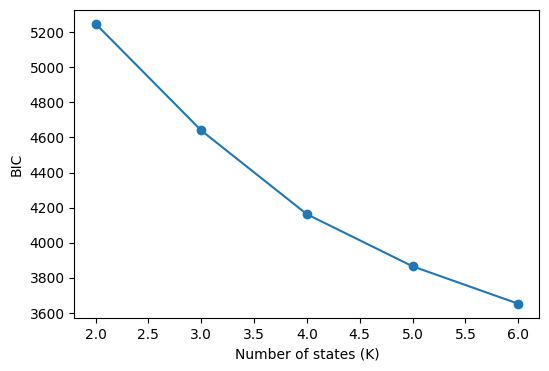

Selected K=6 by BIC (best seed=8).
Transition matrix (states ordered low→high):


,s0,s1,s2,s3,s4,s5
s0,0.98,0.01,0.01,0.00,0.00,0.00
s1,0.23,0.77,0.01,0.00,0.00,0.00
s2,0.00,0.20,0.78,0.02,0.00,0.00
s3,0.00,0.00,0.29,0.69,0.00,0.01
s4,0.00,0.00,0.00,0.24,0.76,0.00
s5,0.00,0.00,0.00,0.00,0.22,0.78


Expected vs empirical duration by state (with censoring-aware summaries):


,state,model_p_ii,model_expected_duration,emp_p_ii,emp_expected_duration,n_runs,emp_mean_all,emp_median_all,emp_p90_all,n_runs_non_censored,emp_mean_non_censored,emp_median_non_censored,censor_rate
0,0,0.98,53.03,0.98,55.00,42,3.57,2.50,7.90,2,5.50,5.50,0.95
1,1,0.77,4.26,0.78,4.51,65,3.32,3.00,6.00,43,3.16,3.00,0.34
2,2,0.78,4.59,0.79,4.75,84,3.86,3.00,8.00,64,4.23,3.50,0.24
3,3,0.69,3.28,0.70,3.31,78,3.10,2.00,6.30,71,3.08,2.00,0.09
4,4,0.76,4.09,0.77,4.28,69,4.04,3.00,7.00,64,3.97,3.00,0.07
5,5,0.78,4.61,0.77,4.44,59,4.44,4.00,7.00,59,4.44,4.00,0.00


Distribution of LAST observed state (end-of-spell):


,state,count_last_state,share_last_state
0,0,40,0.43
1,1,22,0.23
2,2,20,0.21
3,3,7,0.07
4,4,5,0.05


Runs exited vs censored by state:


,state,runs_total,runs_censored,runs_exited,censor_rate
0,0,42,40,2,0.95
1,1,65,22,43,0.34
2,2,84,20,64,0.24
3,3,78,7,71,0.09
4,4,69,5,64,0.07
5,5,59,0,59,0.00


In [37]:
# Weekly dataframe for HMM (feature table for downstream analysis)
GROUP_COLS = ("movie_odid","spell_id")
SORT_COL = "week_in_spell" if "week_in_spell" in weekly_hmm.columns else "week_index"

hmm_df = weekly_hmm.copy()
hmm_df = hmm_df.sort_values(list(GROUP_COLS) + [SORT_COL]).reset_index(drop=True)

# -------------------------------
# Choose what the HMM observes
# -------------------------------
OBS_COL = "log_revenue_deseason"   # change to "log_rpt_deseason" to fit demand tiers instead

if OBS_COL not in hmm_df.columns:
    raise ValueError(f"{OBS_COL} not found in weekly_hmm. Did you run preprocessing + seasonality cells?")

# -------------------------------
# K sweep (same obs as final fit)
# -------------------------------
k_table, models = k_sweep(
    hmm_df,
    obs_cols=(OBS_COL,),
    Ks=range(2, 7),
    group_cols=GROUP_COLS
)
display(k_table)

plt.figure(figsize=(6,4))
plt.plot(k_table["K"], k_table["BIC"], marker="o")
plt.xlabel("Number of states (K)")
plt.ylabel("BIC")
plt.show()

K = int(k_table.loc[k_table["BIC"].idxmin(), "K"])
best_seed = int(k_table.loc[k_table["BIC"].idxmin(), "seed"])
print(f"Selected K={K} by BIC (best seed={best_seed}).")

# -------------------------------
# Build X/lengths in the exact order used for the fit
# -------------------------------
d_fit, X, lengths = build_X_lengths(hmm_df, obs_cols=(OBS_COL,), group_cols=GROUP_COLS)

# Use the best model from the sweep (already fit on the same X/lengths)
hmm_model = models[K]["model"]

# Decode + posterior
state_raw = hmm_model.predict(X, lengths)
gamma_raw = hmm_model.predict_proba(X, lengths)

# Relabel states by mean (low->high)
means_raw = hmm_model.means_.reshape(-1)
order = np.argsort(means_raw)                # raw index order low->high
inv_order = np.empty_like(order)
inv_order[order] = np.arange(K)              # raw -> ranked
state_ranked = inv_order[state_raw]

# Reorder posterior columns to ranked order and name them state_0..state_{K-1}
STATE_COLS = [f"state_{i}" for i in range(K)]
gamma = gamma_raw[:, order]
gamma_df = pd.DataFrame(gamma, columns=STATE_COLS, index=d_fit.index)

# Attach to fitted rows
d_fit = d_fit.copy()
d_fit["state_raw"] = state_raw
d_fit["state"] = state_ranked
d_fit = pd.concat([d_fit, gamma_df], axis=1)

# For downstream cells that expect hmm_df to contain the decoded states
hmm_df = d_fit

# -------------------------------
# Movie-level state shares (SOFT: average posterior probs)
# -------------------------------
movie_state_share = d_fit.groupby("movie_odid")[STATE_COLS].mean().reset_index()

movie_master_50_hmm = movie_master_50.merge(
    movie_state_share,
    on="movie_odid",
    how="left"
)

# -------------------------------
# Diagnostics (ordered states)
# -------------------------------
import numpy as np
import pandas as pd

# --- Robustly pick group/time columns used in your notebook ---
group_cols = GROUP_COLS if "GROUP_COLS" in globals() else (["movie_odid","spell_id"] if "spell_id" in hmm_df.columns else ["movie_odid"])
time_col   = SORT_COL if "SORT_COL" in globals() else ("week_in_spell" if "week_in_spell" in hmm_df.columns else "week_index")

# --- Transition matrix in ordered state-space (low->high) ---
means_raw = hmm_model.means_.ravel()
order = np.argsort(means_raw)
P_sorted = hmm_model.transmat_[order][:, order]

P_df = pd.DataFrame(P_sorted, index=[f"s{i}" for i in range(K)], columns=[f"s{i}" for i in range(K)])
print("Transition matrix (states ordered low→high):")
display(P_df)

p_ii = np.diag(P_sorted)
expected = 1.0 / (1.0 - p_ii)

# --- Empirical run lengths WITH censoring info ---
def run_lengths_with_censor(states):
    out = []
    if len(states) == 0:
        return out
    cur = states[0]
    L = 1
    for s in states[1:]:
        if s == cur:
            L += 1
        else:
            out.append({"state": int(cur), "run_len": int(L), "censored": 0})
            cur = s
            L = 1
    # last run ends because sequence ends (right-censored)
    out.append({"state": int(cur), "run_len": int(L), "censored": 1})
    return out

runs = []
trans_counts = np.zeros((K, K), dtype=int)

group_cols_list = list(group_cols)  # fixes tuple/list concat issues
for _, g in hmm_df.sort_values(group_cols_list + [time_col]).groupby(group_cols_list):
    st = g["state"].to_numpy()
    if len(st) < 2:
        runs.extend(run_lengths_with_censor(st))
        continue

    runs.extend(run_lengths_with_censor(st))
    for a, b in zip(st[:-1], st[1:]):
        trans_counts[int(a), int(b)] += 1

run_df = pd.DataFrame(runs)

# Run-length summaries (all runs)
emp_all = run_df.groupby("state")["run_len"].agg(
    n_runs="count",
    emp_mean_all="mean",
    emp_median_all="median",
    emp_p90_all=lambda x: np.quantile(x, 0.90)
).reset_index()

# Run-length summaries (non-censored runs only)
emp_nc = run_df[run_df["censored"] == 0].groupby("state")["run_len"].agg(
    n_runs_non_censored="count",
    emp_mean_non_censored="mean",
    emp_median_non_censored="median"
).reset_index()

# Censoring rate by state (share of runs that end due to sequence ending)
censor_rate = run_df.groupby("state")["censored"].mean().reset_index().rename(columns={"censored": "censor_rate"})

# Empirical transition-based p_ii (from within-sequence transitions only)
row_sums = trans_counts.sum(axis=1, keepdims=True)
emp_P = np.divide(trans_counts, row_sums, where=row_sums > 0)
emp_pii = np.diag(emp_P)
emp_expected = np.where(emp_pii < 1, 1.0 / (1.0 - emp_pii), np.inf)

dur_df = pd.DataFrame({
    "state": np.arange(K),
    "model_p_ii": np.diag(P_sorted),
    "model_expected_duration": 1.0 / (1.0 - np.diag(P_sorted)),
    "emp_p_ii": emp_pii,
    "emp_expected_duration": emp_expected
})

dur_check = (dur_df
             .merge(emp_all, on="state", how="left")
             .merge(emp_nc, on="state", how="left")
             .merge(censor_rate, on="state", how="left"))

print("Expected vs empirical duration by state (with censoring-aware summaries):")
display(dur_check)

# --- Which state is most often the last observed state? (terminal behavior) ---
group_cols_list = list(group_cols)
last_state = (hmm_df.sort_values(group_cols_list + [time_col])
              .groupby(group_cols_list)["state"]
              .last()
              .value_counts()
              .sort_index())

last_state_df = pd.DataFrame({
    "state": last_state.index,
    "count_last_state": last_state.values,
    "share_last_state": last_state.values / last_state.values.sum()
})
print("Distribution of LAST observed state (end-of-spell):")
display(last_state_df)

# --- Exits vs censoring by state (counts) ---
run_counts = run_df.groupby("state").agg(
    runs_total=("run_len","count"),
    runs_censored=("censored","sum"),
)
run_counts["runs_exited"] = run_counts["runs_total"] - run_counts["runs_censored"]
run_counts["censor_rate"] = run_counts["runs_censored"] / run_counts["runs_total"]
print("Runs exited vs censored by state:")
display(run_counts.reset_index())


# Robustness checks and model diagnostics (coding)

These cells address key advisor concerns about (i) sensitivity to modeling choices, (ii) uncertainty/stability of the HMM fit, (iii) seasonality, and (iv) using *fractions of time* vs *absolute time* as downstream regression features.


In [12]:
# ------------------------------------------------------------
# 1) Additional movie-level HMM features:
#    - expected weeks in each state (soft counts)
#    - entropy of the state-share distribution
#    - number of state transitions (within spells, summed per movie)
#    - max state reached
# These support the advisor's "fractions vs absolute time" concern.
# ------------------------------------------------------------

# Expected weeks in each state (soft counts = sum of posterior probs across weeks)
rev_weeks = hmm_df.groupby("movie_odid")[STATE_COLS].sum().reset_index()
rev_weeks = rev_weeks.rename(columns={c: f"rev_weeks_{c}" for c in STATE_COLS})

# Entropy of state shares (higher = more mixed across tiers)
p = movie_master_50_hmm[STATE_COLS].to_numpy()
movie_master_50_hmm["rev_state_entropy"] = -np.nansum(p * np.log(np.clip(p, 1e-12, 1.0)), axis=1)

# Transitions within each spell, then summed per movie
def _n_transitions(arr):
    if len(arr) < 2:
        return 0
    return int(np.sum(arr[1:] != arr[:-1]))

trans_per_spell = (
    hmm_df.sort_values(list(GROUP_COLS) + [SORT_COL])
          .groupby(list(GROUP_COLS))["state"]
          .apply(lambda s: _n_transitions(s.to_numpy()))
          .rename("rev_transitions_spell")
          .reset_index()
)
trans_per_movie = (
    trans_per_spell.groupby("movie_odid")["rev_transitions_spell"]
                   .sum()
                   .rename("rev_n_transitions")
                   .reset_index()
)

max_state = (
    hmm_df.groupby("movie_odid")["state"]
          .max()
          .rename("rev_max_state")
          .reset_index()
)

# Merge new features onto movie_master_50_hmm
movie_master_50_hmm = (
    movie_master_50_hmm.merge(rev_weeks, on="movie_odid", how="left")
                       .merge(trans_per_movie, on="movie_odid", how="left")
                       .merge(max_state, on="movie_odid", how="left")
)

print("Added columns:", [f"rev_weeks_{c}" for c in STATE_COLS] + ["rev_state_entropy","rev_n_transitions","rev_max_state"])
display(movie_master_50_hmm[["movie_name","weeks_in_release"] + STATE_COLS + ["rev_state_entropy","rev_n_transitions","rev_max_state"]].head())


Added columns: ['rev_weeks_state_0', 'rev_weeks_state_1', 'rev_weeks_state_2', 'rev_weeks_state_3', 'rev_weeks_state_4', 'rev_weeks_state_5', 'rev_state_entropy', 'rev_n_transitions', 'rev_max_state']


,movie_name,weeks_in_release,state_0,state_1,state_2,state_3,state_4,state_5,rev_state_entropy,rev_n_transitions,rev_max_state
0,Titanic,56,0.09,0.07,0.24,0.16,0.14,0.30,1.67,13,5
1,The Dark Knight,33,0.08,0.20,0.37,0.07,0.12,0.16,1.63,7,5
2,Star Wars Ep. IV: A New Hope,42,0.00,0.08,0.19,0.21,0.41,0.10,1.45,6,5
3,Shrek 2,17,0.00,0.06,0.20,0.22,0.21,0.32,1.51,5,5
4,E.T. the Extra-Terrestrial,61,0.02,0.04,0.15,0.24,0.49,0.07,1.34,9,5


In [31]:
# ------------------------------------------------------------
# 2) Emission sanity checks (Gaussianity) + seed stability
# ------------------------------------------------------------
from scipy import stats
import pandas as pd
import numpy as np

# (a) Gaussianity diagnostics per state (hard assignment)
rows = []
for s in range(K):
    vals = hmm_df.loc[hmm_df["state"] == s, OBS_COL].dropna().to_numpy()
    n = len(vals)
    if n >= 8:
        normaltest_p = stats.normaltest(vals).pvalue  # D'Agostino-Pearson
        jb_p = stats.jarque_bera(vals).pvalue
    else:
        normaltest_p = np.nan
        jb_p = np.nan
    rows.append({
        "state": s,
        "n_weeks": n,
        "mean": float(np.mean(vals)) if n else np.nan,
        "sd": float(np.std(vals, ddof=1)) if n > 1 else np.nan,
        "skew": float(stats.skew(vals)) if n > 2 else np.nan,
        "kurtosis(excess)": float(stats.kurtosis(vals, fisher=True)) if n > 3 else np.nan,
        "normaltest_p": float(normaltest_p) if not np.isnan(normaltest_p) else np.nan,
        "jarque_bera_p": float(jb_p) if not np.isnan(jb_p) else np.nan,
    })

gauss_diag = pd.DataFrame(rows)
print("Gaussianity diagnostics by state (note: large n can make p-values tiny even for mild deviations):")
display(gauss_diag)

# (b) Seed stability for state means + durations + occupancy
N_SEEDS = 10
seed_means = []
seed_durs  = []
seed_occs  = []
seed_ll    = []

for rs in range(N_SEEDS):
    d_seed, m_seed, _ = fit_hmm_states(
        weekly_hmm, OBS_COL,
        group_cols=GROUP_COLS,
        sort_col=SORT_COL,
        K=K,
        sticky=0.97,
        n_iter=250,
        random_state=rs,
        smooth_blips=False
    )

    # Reconstruct X/lengths exactly as fit_hmm_states used (d_seed is already sorted + non-missing)
    X = d_seed[[OBS_COL]].to_numpy()
    lengths = d_seed.groupby(list(GROUP_COLS))[OBS_COL].size().tolist()

    means_raw = m_seed.means_.reshape(-1)
    order = np.argsort(means_raw)                  # low -> high
    means_sorted = means_raw[order]

    P_sorted = m_seed.transmat_[order][:, order]
    dur_sorted = 1.0 / (1.0 - np.diag(P_sorted))   # expected duration

    gamma_sorted = m_seed.predict_proba(X, lengths)[:, order]
    occ_sorted = gamma_sorted.mean(axis=0)

    seed_means.append(means_sorted)
    seed_durs.append(dur_sorted)
    seed_occs.append(occ_sorted)
    seed_ll.append(m_seed.score(X, lengths))

seed_means = np.vstack(seed_means)
seed_durs  = np.vstack(seed_durs)
seed_occs  = np.vstack(seed_occs)

stability = pd.DataFrame({
    "state": np.arange(K),
    "mean_of_means": seed_means.mean(axis=0),
    "sd_of_means":   seed_means.std(axis=0, ddof=1),
    "mean_duration": seed_durs.mean(axis=0),
    "sd_duration":   seed_durs.std(axis=0, ddof=1),
    "mean_occupancy": seed_occs.mean(axis=0),
    "sd_occupancy":   seed_occs.std(axis=0, ddof=1),
})

print(f"Seed-stability over {N_SEEDS} fits (states sorted low->high within each seed):")
display(stability)

print("Train log-likelihood across seeds (for reference):")
display(pd.Series(seed_ll, name="train_logL").describe())

Gaussianity diagnostics by state (note: large n can make p-values tiny even for mild deviations):


,state,n_weeks,mean,sd,skew,kurtosis(excess),normaltest_p,jarque_bera_p
0,0,150,-3.80,1.00,-1.58,3.21,0.00,0.00
1,1,216,-2.02,0.40,0.12,-0.36,0.42,0.44
2,2,324,-0.90,0.39,0.00,-0.77,0.00,0.02
3,3,242,0.31,0.34,0.05,-0.99,0.00,0.01
4,4,279,1.49,0.36,0.10,-1.11,0.00,0.00
5,5,262,3.09,0.70,0.61,-0.39,0.00,0.00


Seed-stability over 10 fits (states sorted low->high within each seed):


,state,mean_of_means,sd_of_means,mean_duration,sd_duration,mean_occupancy,sd_occupancy
0,0,-3.75,0.00,53.01,0.02,0.10,0.00
1,1,-2.02,0.00,4.26,0.00,0.14,0.00
2,2,-0.90,0.00,4.59,0.00,0.22,0.00
3,3,0.31,0.00,3.28,0.00,0.16,0.00
4,4,1.47,0.00,4.09,0.00,0.18,0.00
5,5,3.04,0.00,4.61,0.00,0.18,0.00


Train log-likelihood across seeds (for reference):


,train_logL
count,10.00
mean,"-1,654.30"
std,0.00
min,"-1,654.31"
25%,"-1,654.30"
50%,"-1,654.30"
75%,"-1,654.30"
max,"-1,654.29"


In [32]:
# ------------------------------------------------------------
# 2.5) Out-of-sample check for K (fold-level + paired deltas)
# (movie/spell-level holdout; not a "forecast next week" task)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import KFold

K_LIST = [5, 6]
N_SPLITS = 5
SEEDS = list(range(10))
STICKY = 0.97
N_ITER = 250
CV_SEED = 7  # for fold shuffling

def fit_best_seed_sticky_hmm(X_train, len_train, K, seeds=SEEDS, sticky=STICKY, n_iter=N_ITER):
    best_model, best_ll, best_seed = None, -np.inf, None
    for rs in seeds:
        m = GaussianHMM(
            n_components=K,
            covariance_type="diag",
            n_iter=n_iter,
            random_state=rs,
            min_covar=1e-3
        )
        m.startprob_ = np.full(K, 1.0 / K)
        trans = np.full((K, K), (1 - sticky) / (K - 1))
        np.fill_diagonal(trans, sticky)
        m.transmat_ = trans
        m.init_params = "mc"
        m.params = "stmc"
        m.fit(X_train, len_train)
        ll = m.score(X_train, len_train)
        if ll > best_ll:
            best_ll, best_model, best_seed = ll, m, rs
    return best_model, best_ll, best_seed

# Build unique groups (movie_id, spell_id) if available; else movie_id only
gdf = hmm_df[list(GROUP_COLS)].drop_duplicates().reset_index(drop=True)
group_keys = [tuple(row) for row in gdf.to_numpy()]  # list of tuples
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CV_SEED)

# For fast masking on hmm_df rows
mi = pd.MultiIndex.from_frame(hmm_df[list(GROUP_COLS)])

rows = []
for fold, (tr_idx, te_idx) in enumerate(kf.split(group_keys), start=1):
    train_keys = [group_keys[i] for i in tr_idx]
    test_keys  = [group_keys[i] for i in te_idx]

    train_mask = mi.isin(train_keys)
    test_mask  = mi.isin(test_keys)

    train_df = hmm_df.loc[train_mask].copy()
    test_df  = hmm_df.loc[test_mask].copy()

    _, Xtr, Ltr = build_X_lengths(train_df, obs_cols=(OBS_COL,), group_cols=GROUP_COLS)
    _, Xte, Lte = build_X_lengths(test_df,  obs_cols=(OBS_COL,), group_cols=GROUP_COLS)

    for K_ in K_LIST:
        model, tr_ll, best_seed = fit_best_seed_sticky_hmm(Xtr, Ltr, K_)
        te_ll = model.score(Xte, Lte)
        rows.append({
            "fold": fold,
            "K": K_,
            "best_seed": best_seed,
            "train_logL": tr_ll,
            "test_logL": te_ll,
            "ll_per_week": te_ll / Xte.shape[0],
            "n_weeks_test": Xte.shape[0],
        })

fold_df = pd.DataFrame(rows).sort_values(["fold", "K"])
print("Fold-level out-of-sample per-week log-likelihood (higher is better):")
display(fold_df)

pivot = fold_df.pivot(index="fold", columns="K", values="ll_per_week")
if 5 in pivot.columns and 6 in pivot.columns:
    pivot["delta_6_minus_5"] = pivot[6] - pivot[5]
    print("Paired fold deltas (K=6 − K=5):")
    display(pivot)

    deltas = pivot["delta_6_minus_5"].dropna().to_numpy()
    mean_d = deltas.mean()
    sd_d   = deltas.std(ddof=1) if len(deltas) > 1 else np.nan
    se_d   = sd_d / np.sqrt(len(deltas)) if len(deltas) > 1 else np.nan
    ci_lo  = mean_d - 1.96 * se_d if len(deltas) > 1 else np.nan
    ci_hi  = mean_d + 1.96 * se_d if len(deltas) > 1 else np.nan
    wins   = int((deltas > 0).sum())

    print(f"Δ (K=6 − K=5): mean={mean_d:.4f}, sd={sd_d:.4f}, 95% CI=[{ci_lo:.4f},{ci_hi:.4f}], wins={wins}/{len(deltas)}")
else:
    print("Pivot is missing K=5 or K=6; check K_LIST.")

Fold-level out-of-sample per-week log-likelihood (higher is better):


,fold,K,best_seed,train_logL,test_logL,ll_per_week,n_weeks_test
0,1,5,0,"-1,474.58",-342.16,-1.32,260
1,1,6,3,"-1,346.78",-314.48,-1.21,260
2,2,5,6,"-1,459.89",-353.39,-1.27,278
3,2,6,6,"-1,337.18",-328.30,-1.18,278
4,3,5,9,"-1,447.37",-368.56,-1.18,312
5,3,6,0,"-1,315.65",-342.47,-1.10,312
6,4,5,1,"-1,461.25",-335.45,-1.31,256
7,4,6,2,"-1,354.02",-315.02,-1.23,256
8,5,5,7,"-1,338.48",-459.51,-1.25,367
9,5,6,8,"-1,234.41",-427.24,-1.16,367


Paired fold deltas (K=6 − K=5):


K,5,6,delta_6_minus_5
fold,,,
1,-1.32,-1.21,0.11
2,-1.27,-1.18,0.09
3,-1.18,-1.10,0.08
4,-1.31,-1.23,0.08
5,-1.25,-1.16,0.09


Δ (K=6 − K=5): mean=0.0896, sd=0.0102, 95% CI=[0.0807,0.0986], wins=5/5


In [15]:
# ------------------------------------------------------------
# 3) Leakage / censoring sensitivity check:
# Fit the model on a fixed early horizon (e.g., first H weeks) and compare means.
# This addresses the concern that the model 'knows' when a film leaves theaters.
# ------------------------------------------------------------
H = 10  # horizon in weeks-within-spell
if "week_in_spell" in weekly_hmm.columns:
    trunc_df = weekly_hmm[weekly_hmm["week_in_spell"] <= H].copy()
else:
    trunc_df = weekly_hmm[weekly_hmm["week_index"] <= H].copy()

trunc_fit, trunc_model, trunc_means = fit_hmm_states(
    trunc_df, OBS_COL,
    group_cols=GROUP_COLS,
    sort_col=("week_in_spell" if "week_in_spell" in trunc_df.columns else "week_index"),
    K=K,
    sticky=0.97,
    n_iter=400,
    random_state=best_seed,
    smooth_blips=False
)

print(f"Full-sample means (low->high) on {OBS_COL}:")
print(means_raw[order])

print(f"Truncated (first {H} weeks) means (low->high) on {OBS_COL}:")
print(trunc_means)

# simple distance metric
diff = np.asarray(trunc_means) - np.asarray(means_raw[order])
print("Mean differences (truncated - full):", diff)
print("Max abs difference:", float(np.max(np.abs(diff))))


Full-sample means (low->high) on log_revenue_deseason:
[-3.74984911 -2.01672009 -0.89889754  0.31055955  1.47381878  3.04422526]
Truncated (first 10 weeks) means (low->high) on log_revenue_deseason:
[-1.82744325  0.21693813  1.21542106  1.88905607  2.50700186  3.49408007]
Mean differences (truncated - full): [1.92240586 2.23365822 2.1143186  1.57849652 1.03318308 0.44985481]
Max abs difference: 2.2336582235818065


In [16]:
# ------------------------------------------------------------
# 4) Old vs. new releases sensitivity:
# Fit separate HMMs on older vs newer movies (by production_year median).
# ------------------------------------------------------------
if "production_year" in movie_master_50.columns:
    cutoff = int(movie_master_50["production_year"].median())
    old_movies = movie_master_50.loc[movie_master_50["production_year"] <= cutoff, "movie_odid"].dropna().unique()
    new_movies = movie_master_50.loc[movie_master_50["production_year"] > cutoff, "movie_odid"].dropna().unique()

    df_old = weekly_hmm[weekly_hmm["movie_odid"].isin(old_movies)].copy()
    df_new = weekly_hmm[weekly_hmm["movie_odid"].isin(new_movies)].copy()

    old_fit, old_model, old_means = fit_hmm_states(
        df_old, OBS_COL,
        group_cols=GROUP_COLS,
        sort_col=SORT_COL,
        K=K, sticky=0.97, n_iter=400, random_state=best_seed, smooth_blips=False
    )
    new_fit, new_model, new_means = fit_hmm_states(
        df_new, OBS_COL,
        group_cols=GROUP_COLS,
        sort_col=SORT_COL,
        K=K, sticky=0.97, n_iter=400, random_state=best_seed, smooth_blips=False
    )

    print(f"Production year cutoff (median): {cutoff}")
    print("Older-movies means (low->high):", old_means)
    print("Newer-movies means (low->high):", new_means)
else:
    print("production_year not found in movie_master_50; skipping this check.")


Production year cutoff (median): 2003
Older-movies means (low->high): [-3.84852685 -2.01562479 -0.82766642  0.34056007  1.45121154  2.92791722]
Newer-movies means (low->high): [-3.09048821 -1.63587455 -0.59534047  0.8479522   2.0366297   3.42263601]


In [42]:
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------
# Helpers
# -----------------------------
def _num_suffix(col):
    m = re.search(r'(\d+)$', col)
    return int(m.group(1)) if m else 10**9

def _ols_robust(df, y, xcols, cov_type="HC3"):
    d = df[[y] + xcols].dropna().copy()
    X = sm.add_constant(d[xcols], has_constant="add")
    m = sm.OLS(d[y], X).fit(cov_type=cov_type)
    return m, len(d)

def _coef_table(model):
    return (pd.DataFrame({
        "term": model.params.index,
        "coef": model.params.values,
        "se": model.bse,
        "p": model.pvalues
    })
    .sort_values("p")
    .reset_index(drop=True))

def _model_row(name, model, n):
    return {"model": name, "n": n, "R2": model.rsquared, "Adj_R2": model.rsquared_adj, "AIC": model.aic}

# -----------------------------
# Data + feature discovery
# -----------------------------
df = movie_master_50_hmm.copy()

# shares: state_0 ... state_5
SHARE_COLS = sorted([c for c in df.columns if re.fullmatch(r"state_\d+", c)], key=_num_suffix)
if len(SHARE_COLS) == 0:
    raise ValueError("No share columns found (expected columns like state_0, state_1, ...).")

if "weeks_in_release" not in df.columns:
    raise ValueError("weeks_in_release column missing; needed to compute expected weeks in each state.")

# counts columns: if not present, create them from shares
# exp_weeks_state_i = state_i_share * weeks_in_release
COUNT_COLS = sorted([c for c in df.columns if re.fullmatch(r"exp_weeks_state_\d+", c)], key=_num_suffix)

if len(COUNT_COLS) == 0:
    for s_col in SHARE_COLS:
        i = _num_suffix(s_col)
        df[f"exp_weeks_state_{i}"] = df[s_col] * df["weeks_in_release"]
    COUNT_COLS = sorted([c for c in df.columns if re.fullmatch(r"exp_weeks_state_\d+", c)], key=_num_suffix)

BASE_SHARE = SHARE_COLS[0]
BASE_COUNT = COUNT_COLS[0]
SHARE_X = [c for c in SHARE_COLS if c != BASE_SHARE]
COUNT_X = [c for c in COUNT_COLS if c != BASE_COUNT]

# -----------------------------
# Add last_is_tail if missing (computed from hmm_df)
# -----------------------------
if "last_is_tail" not in df.columns:
    if "week_index" in hmm_df.columns:
        sort_cols = ["movie_odid", "week_index"]
    else:
        sort_cols = ["movie_odid"] + (["spell_id"] if "spell_id" in hmm_df.columns else []) + \
                    (["week_in_spell"] if "week_in_spell" in hmm_df.columns else ["week_index"])

    last_state = (hmm_df.sort_values(sort_cols)
                  .groupby("movie_odid")["state"]
                  .last())
    tail = (last_state == 0).astype(int).rename("last_is_tail").reset_index()
    df = df.merge(tail, on="movie_odid", how="left")

# -----------------------------
# ROI regressions
# -----------------------------
Y_ROI = "roi_worldwide"
X_base = ["log_production_budget", "weeks_in_release"]
X_shares = X_base + SHARE_X
X_counts = ["log_production_budget"] + COUNT_X          # weeks omitted by construction (counts already include time)
X_counts_tail = X_counts + ["last_is_tail"]

mA, nA = _ols_robust(df, Y_ROI, X_base)
mB, nB = _ols_robust(df, Y_ROI, X_shares)
mC, nC = _ols_robust(df, Y_ROI, X_counts)
mCt, nCt = _ols_robust(df, Y_ROI, X_counts_tail)

roi_comp = pd.DataFrame([
    _model_row("A: base", mA, nA),
    _model_row("B: shares+weeks", mB, nB),
    _model_row("C: counts", mC, nC),
    _model_row("C+: counts + last_is_tail", mCt, nCt),
])

print("ROI model comparison (robust SE; counts omits weeks_in_release by construction):")
display(roi_comp)

print(f"\nModel B (shares) coefficients (baseline dropped = {BASE_SHARE}):")
display(_coef_table(mB))

print(f"\nModel C (counts) coefficients (baseline dropped = {BASE_COUNT}):")
display(_coef_table(mC))

print("\nModel C+ (counts + last_is_tail) coefficients:")
display(_coef_table(mCt))

# -----------------------------
# log(worldwide box office) regressions
# -----------------------------
Y_GROSS = "log_worldwide_box_office"
mA2, nA2 = _ols_robust(df, Y_GROSS, X_base)
mB2, nB2 = _ols_robust(df, Y_GROSS, X_shares)
mC2, nC2 = _ols_robust(df, Y_GROSS, X_counts)

gross_comp = pd.DataFrame([
    _model_row("A: base", mA2, nA2),
    _model_row("B: shares+weeks", mB2, nB2),
    _model_row("C: counts", mC2, nC2),
])

print("\nlog_worldwide_box_office model comparison:")
display(gross_comp)

print(f"\nModel B2 (shares) coefficients (baseline dropped = {BASE_SHARE}):")
display(_coef_table(mB2))

print(f"\nModel C2 (counts) coefficients (baseline dropped = {BASE_COUNT}):")
display(_coef_table(mC2))

ROI model comparison (robust SE; counts omits weeks_in_release by construction):


,model,n,R2,Adj_R2,AIC
0,A: base,50,0.70,0.69,354.98
1,B: shares+weeks,50,0.77,0.73,351.69
2,C: counts,50,0.84,0.82,330.33
3,C+: counts + last_is_tail,50,0.85,0.82,331.05



Model B (shares) coefficients (baseline dropped = state_0):


,term,coef,se,p
0,log_production_budget,-9.52,2.43,0.00
1,const,166.91,46.78,0.00
2,state_4,57.70,34.50,0.09
3,weeks_in_release,0.21,0.14,0.12
4,state_5,14.48,14.75,0.33
5,state_3,-14.09,17.47,0.42
6,state_1,7.97,15.81,0.61
7,state_2,4.16,15.22,0.78



Model C (counts) coefficients (baseline dropped = exp_weeks_state_0):


,term,coef,se,p
0,const,170.43,40.94,0.00
1,log_production_budget,-8.92,2.16,0.00
2,exp_weeks_state_4,1.92,0.71,0.01
3,exp_weeks_state_3,-0.96,0.58,0.10
4,exp_weeks_state_1,-0.25,0.43,0.55
5,exp_weeks_state_2,0.04,0.43,0.92
6,exp_weeks_state_5,0.01,0.45,0.98



Model C+ (counts + last_is_tail) coefficients:


,term,coef,se,p
0,const,173.85,43.68,0.00
1,log_production_budget,-9.06,2.28,0.00
2,exp_weeks_state_4,1.92,0.83,0.02
3,exp_weeks_state_3,-1.04,0.60,0.08
4,last_is_tail,-1.89,2.43,0.44
5,exp_weeks_state_1,-0.25,0.44,0.57
6,exp_weeks_state_2,0.09,0.44,0.84
7,exp_weeks_state_5,0.02,0.41,0.96



log_worldwide_box_office model comparison:


,model,n,R2,Adj_R2,AIC
0,A: base,50,0.33,0.31,15.73
1,B: shares+weeks,50,0.43,0.33,18.35
2,C: counts,50,0.44,0.36,15.41



Model B2 (shares) coefficients (baseline dropped = state_0):


,term,coef,se,p
0,const,14.06,2.12,0.00
1,log_production_budget,0.33,0.10,0.00
2,weeks_in_release,0.01,0.01,0.04
3,state_4,0.96,0.96,0.32
4,state_1,-0.88,1.10,0.43
5,state_2,-0.30,0.88,0.73
6,state_3,-0.19,0.91,0.84
7,state_5,0.19,1.26,0.88



Model C2 (counts) coefficients (baseline dropped = exp_weeks_state_0):


,term,coef,se,p
0,const,15.13,1.54,0.00
1,log_production_budget,0.27,0.08,0.00
2,exp_weeks_state_4,0.03,0.01,0.05
3,exp_weeks_state_5,0.04,0.03,0.22
4,exp_weeks_state_2,0.01,0.02,0.46
5,exp_weeks_state_1,-0.01,0.02,0.55
6,exp_weeks_state_3,0.00,0.01,0.81


In [18]:
# ------------------------------------------------------------
# 6) Add demand-intensity (rev/theater) state shares for comparison
# (kept separate so we don't overwrite STATE_COLS used downstream)
# ------------------------------------------------------------
OBS_COL_RPT = "log_rpt_deseason"
if OBS_COL_RPT not in weekly_hmm.columns:
    print(f"{OBS_COL_RPT} missing; skipping demand-tier features.")
else:
    # Use the same grouping/sorting logic
    rpt_df = weekly_hmm.sort_values(list(GROUP_COLS) + [SORT_COL]).copy()

    k_table_rpt, models_rpt = k_sweep(
        rpt_df,
        obs_cols=(OBS_COL_RPT,),
        Ks=range(2, 7),
        group_cols=GROUP_COLS
    )
    display(k_table_rpt)

    K_rpt = int(k_table_rpt.loc[k_table_rpt["BIC"].idxmin(), "K"])
    seed_rpt = int(k_table_rpt.loc[k_table_rpt["BIC"].idxmin(), "seed"])
    print(f"Selected K_rpt={K_rpt} by BIC (best seed={seed_rpt}).")

    d_rpt, X_rpt, len_rpt = build_X_lengths(rpt_df, obs_cols=(OBS_COL_RPT,), group_cols=GROUP_COLS)
    rpt_model = models_rpt[K_rpt]["model"]

    # Posterior probs (rank states low->high by mean)
    s_raw = rpt_model.predict(X_rpt, len_rpt)
    g_raw = rpt_model.predict_proba(X_rpt, len_rpt)

    means_raw_rpt = rpt_model.means_.reshape(-1)
    order_rpt = np.argsort(means_raw_rpt)
    inv_rpt = np.empty_like(order_rpt)
    inv_rpt[order_rpt] = np.arange(K_rpt)

    g = g_raw[:, order_rpt]
    RPT_STATE_COLS = [f"rpt_state_{i}" for i in range(K_rpt)]
    g_df = pd.DataFrame(g, columns=RPT_STATE_COLS, index=d_rpt.index)

    d_rpt = d_rpt.copy()
    d_rpt["rpt_state"] = inv_rpt[s_raw]
    d_rpt = pd.concat([d_rpt, g_df], axis=1)

    # Movie-level shares + expected weeks
    rpt_share = d_rpt.groupby("movie_odid")[RPT_STATE_COLS].mean().reset_index()
    rpt_weeks = d_rpt.groupby("movie_odid")[RPT_STATE_COLS].sum().reset_index()
    rpt_weeks = rpt_weeks.rename(columns={c: f"rpt_weeks_{c}" for c in RPT_STATE_COLS})

    movie_master_50_hmm = (
        movie_master_50_hmm.merge(rpt_share, on="movie_odid", how="left")
                           .merge(rpt_weeks, on="movie_odid", how="left")
    )

    print("Added demand-tier columns:", RPT_STATE_COLS)
    display(movie_master_50_hmm[["movie_name"] + RPT_STATE_COLS].head())

    # Quick comparison: correlation between revenue-tier and demand-tier shares
    common = movie_master_50_hmm.dropna(subset=STATE_COLS + RPT_STATE_COLS)
    if len(common) > 5:
        corr = common[STATE_COLS + RPT_STATE_COLS].corr().loc[STATE_COLS, RPT_STATE_COLS]
        print("Correlation (rev-tier shares vs demand-tier shares):")
        display(corr)


,K,seed,logL,AIC,BIC
0,2,0,"-1,553.59","3,121.17","3,158.24"
1,3,6,"-1,235.02","2,498.04","2,572.17"
2,4,8,"-1,001.67","2,049.34","2,171.12"
3,5,1,-828.28,"1,724.56","1,904.59"
4,6,1,-727.02,"1,548.03","1,796.90"


Selected K_rpt=6 by BIC (best seed=1).
Added demand-tier columns: ['rpt_state_0', 'rpt_state_1', 'rpt_state_2', 'rpt_state_3', 'rpt_state_4', 'rpt_state_5']


,movie_name,rpt_state_0,rpt_state_1,rpt_state_2,rpt_state_3,rpt_state_4,rpt_state_5
0,Titanic,0.14,0.33,0.14,0.12,0.10,0.17
1,The Dark Knight,0.04,0.17,0.56,0.09,0.05,0.09
2,Star Wars Ep. IV: A New Hope,0.08,0.14,0.10,0.11,0.35,0.22
3,Shrek 2,0.17,0.16,0.21,0.18,0.10,0.19
4,E.T. the Extra-Terrestrial,0.10,0.09,0.18,0.39,0.15,0.10


Correlation (rev-tier shares vs demand-tier shares):


,rpt_state_0,rpt_state_1,rpt_state_2,rpt_state_3,rpt_state_4,rpt_state_5
state_0,0.62,-0.04,-0.26,-0.16,-0.32,-0.26
state_1,0.17,0.30,-0.11,-0.30,-0.19,-0.24
state_2,-0.35,0.23,0.34,0.10,-0.29,-0.19
state_3,-0.42,-0.08,0.33,0.30,0.22,-0.05
state_4,-0.23,-0.36,-0.06,0.24,0.49,0.55
state_5,0.20,0.00,-0.20,-0.21,0.04,0.11


# Results

/tmp/ipython-input-278/1369730414.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("RdYlGn", K_plot)


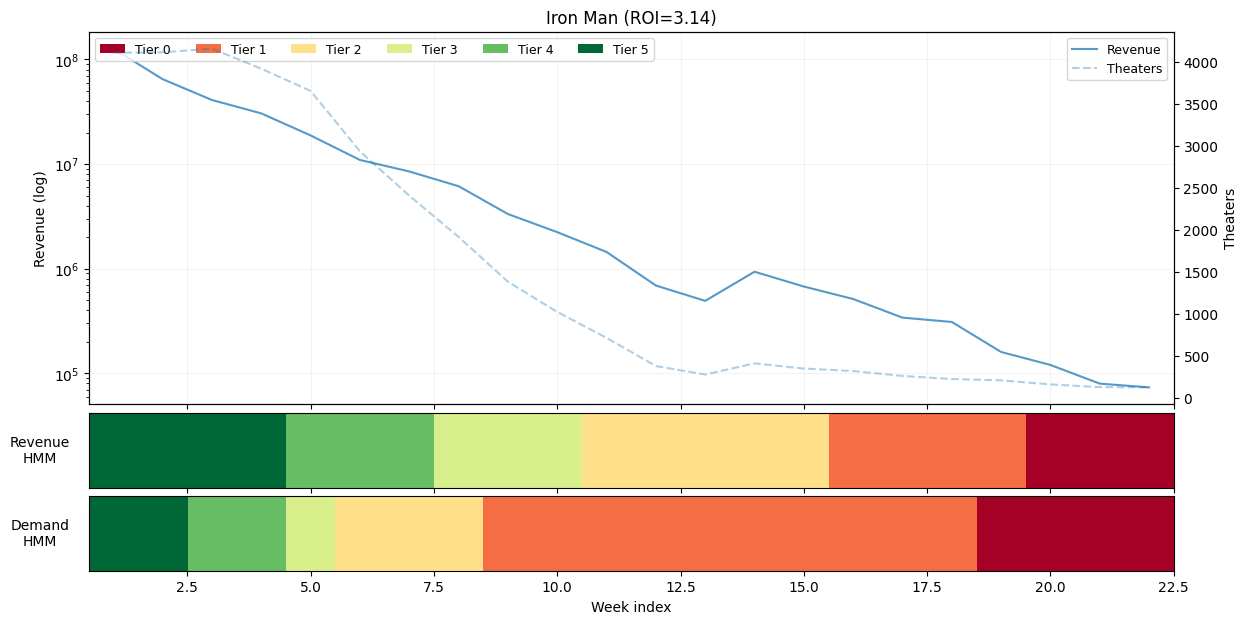

In [43]:
def plot_hmm_state_strips(movie_odid, df=hmm_compare_df, meta_df=movie_master_50,
                          logy=True, show_theaters=True, show_spells=True,
                          break_spells=True):
    d = df[df["movie_odid"] == movie_odid].sort_values(["spell_id", "week_in_spell", "week_index"]).copy()
    if d.empty:
        raise ValueError("No rows for that movie_odid")

    # Title with ROI
    row = meta_df[meta_df["movie_odid"] == movie_odid]
    if len(row):
        name = row["movie_name"].iloc[0]
        roi = row["roi_worldwide"].iloc[0] if "roi_worldwide" in row.columns else np.nan
        title = f"{name} (ROI={roi:.2f})" if pd.notna(roi) else name
    else:
        title = f"movie_odid={movie_odid}"

    # raw arrays
    x_raw = d["week_index"].to_numpy()
    y_raw = d["revenue"].to_numpy()

    s_rev = d["state_rev_deseason"].to_numpy()
    s_rpt = d["state_rpt_deseason"].to_numpy()

    # infer K from the strips (max state + 1)
    K_plot = int(np.nanmax([np.nanmax(s_rev), np.nanmax(s_rpt)]) + 1)
    cmap = plt.cm.get_cmap("RdYlGn", K_plot)

    # Optional: break lines between spells by inserting NaNs
    if break_spells and ("week_in_spell" in d.columns):
        x_plot, y_plot = [], []
        t_plot = [] if (show_theaters and "theaters" in d.columns) else None

        theaters_raw = d["theaters"].to_numpy() if t_plot is not None else None
        w_in_spell = d["week_in_spell"].to_numpy()

        for i in range(len(d)):
            if i > 0 and w_in_spell[i] == 1:
                x_plot.append(np.nan)
                y_plot.append(np.nan)
                if t_plot is not None:
                    t_plot.append(np.nan)

            x_plot.append(x_raw[i])
            y_plot.append(y_raw[i])
            if t_plot is not None:
                t_plot.append(theaters_raw[i])

        x_plot = np.array(x_plot, dtype=float)
        y_plot = np.array(y_plot, dtype=float)
        if t_plot is not None:
            t_plot = np.array(t_plot, dtype=float)
    else:
        x_plot, y_plot = x_raw, y_raw
        t_plot = d["theaters"].to_numpy() if (show_theaters and "theaters" in d.columns) else None

    fig, axes = plt.subplots(
        3, 1, figsize=(14, 7),
        sharex=True,
        gridspec_kw={"height_ratios": [4, 0.8, 0.8], "hspace": 0.05}
    )
    ax0, ax1, ax2 = axes

    # ---- Panel 1: revenue (+ optional theaters)
    rev_line, = ax0.plot(x_plot, y_plot, alpha=0.75, label="Revenue")

    if logy:
        ax0.set_yscale("log")
        ax0.set_ylabel("Revenue (log)")
    else:
        ax0.set_ylabel("Revenue")

    ax0.set_title(title)
    ax0.grid(alpha=0.15)

    line_legend = ax0.legend([rev_line], ["Revenue"], loc="upper right", fontsize=9)

    if t_plot is not None:
        ax0b = ax0.twinx()
        th_line, = ax0b.plot(x_plot, t_plot, alpha=0.35, linestyle="--", linewidth=1.5, label="Theaters")
        ax0b.set_ylabel("Theaters")
        line_legend = ax0.legend([rev_line, th_line], ["Revenue", "Theaters"], loc="upper right", fontsize=9)

    # ---- Panel 2: Revenue HMM strip
    ax1.imshow(
        s_rev[np.newaxis, :],
        aspect="auto",
        cmap=cmap,
        vmin=0, vmax=K_plot-1,
        extent=[x_raw.min()-0.5, x_raw.max()+0.5, 0, 1]
    )
    ax1.set_yticks([])
    ax1.set_ylabel("Revenue\nHMM", rotation=0, labelpad=35, va="center")

    # ---- Panel 3: Demand HMM strip
    ax2.imshow(
        s_rpt[np.newaxis, :],
        aspect="auto",
        cmap=cmap,
        vmin=0, vmax=K_plot-1,
        extent=[x_raw.min()-0.5, x_raw.max()+0.5, 0, 1]
    )
    ax2.set_yticks([])
    ax2.set_ylabel("Demand\nHMM", rotation=0, labelpad=35, va="center")
    ax2.set_xlabel("Week index")

    # ---- Spell markers
    if show_spells and ("week_in_spell" in d.columns):
        start_rows = d[d["week_in_spell"] == 1].copy().sort_values(["spell_id", "chart_date"])
        start_rows = start_rows[start_rows["week_index"] != int(np.nanmin(x_raw))]

        label_once = True
        for _, r in start_rows.iterrows():
            v = int(r["week_index"])
            label = pd.to_datetime(r["chart_date"]).strftime("%Y-%m")

            for ax in axes:
                ax.axvline(
                    v,
                    linestyle=":",
                    color="gray",
                    linewidth=1.2,
                    alpha=1,
                    label="Spell start" if label_once else None
                )
            label_once = False

            ax0.text(
                v,
                ax0.get_ylim()[1],
                label,
                va="bottom",
                ha="right",
                fontsize=9,
                alpha=1,
                color="gray"
            )

    # ---- State legend (top-left): show all K tiers
    state_legend = [
        Patch(facecolor=cmap(s), edgecolor="none", label=f"Tier {s}")
        for s in range(K_plot)
    ]
    ax0.legend(handles=state_legend, loc="upper left", ncol=min(K_plot, 6), fontsize=9)

    # Re-add Revenue/Theaters legend if it exists
    if line_legend is not None:
        ax0.add_artist(line_legend)

    plt.show()


cand = movie_master_50[movie_master_50["movie_name"].astype(str).str.contains(r"Iron Man", case=False, na=False)]
et_odid = cand["movie_odid"].iloc[0]

plot_hmm_state_strips(et_odid, logy=True, show_theaters=True, show_spells=True)


In [20]:
# Sort states by mean log-revenue in ascending order
state_means = (
    hmm_df.groupby('state')[OBS_COL]
    .mean()
    .sort_values()
)

print('States by log-revenue mean (ascending):')
display(state_means)

States by log-revenue mean (ascending):


,log_revenue_deseason
state,
0,-3.80
1,-2.02
2,-0.90
3,0.31
4,1.49
5,3.09


In [21]:
# Determine correlation of worldwide ROI with budget, weeks, and state shares
corr_cols = ['roi_worldwide', 'production_budget', 'weeks_in_release'] + STATE_COLS
corr_matrix = movie_master_50_hmm[corr_cols].corr()

print('Correlation of worldwide ROI:')
display(corr_matrix['roi_worldwide'].sort_values(ascending=False))


Correlation of worldwide ROI:


,roi_worldwide
roi_worldwide,1.00
state_4,0.74
weeks_in_release,0.33
state_3,0.28
state_0,-0.21
state_2,-0.22
state_5,-0.33
state_1,-0.39
production_budget,-0.62


In [22]:
# Mean state shares for successful vs. unsuccessful films
success_state_means = movie_master_50_hmm.groupby('success_indicator')[STATE_COLS].mean()

print('Mean state shares based on whether film is successful (True/False):')
display(success_state_means)


Mean state shares based on whether film is successful (True/False):


,state_0,state_1,state_2,state_3,state_4,state_5
success_indicator,,,,,,
True,0.09,0.15,0.22,0.15,0.18,0.20


In [23]:
# Create ROI-based groups based on median ROI
median_roi = movie_master_50_hmm['roi_worldwide'].median()

movie_master_50_hmm['roi_group'] = np.where(
    movie_master_50_hmm['roi_worldwide'] >= median_roi,
    'high_roi',
    'low_roi',
)

roi_state_means = movie_master_50_hmm.groupby('roi_group')[STATE_COLS].mean()

print('Median ROI:', median_roi)
print('\nMean state shares by ROI group:')
display(roi_state_means)


Median ROI: 7.541632157217391

Mean state shares by ROI group:


,state_0,state_1,state_2,state_3,state_4,state_5
roi_group,,,,,,
high_roi,0.09,0.11,0.20,0.19,0.22,0.18
low_roi,0.09,0.19,0.25,0.11,0.13,0.22


In [24]:
# Summary statistics by ROI group: budgets, weeks, and state shares
summary_cols = ['roi_worldwide', 'production_budget', 'weeks_in_release'] + STATE_COLS
summary_by_roi = movie_master_50_hmm.groupby('roi_group')[summary_cols].agg(['mean', 'median'])

print('Summary statistics by ROI group:')
display(summary_by_roi)


Summary statistics by ROI group:


roi_worldwide        production_budget                weeks_in_release        state_0        state_1         \
                   mean median              mean         median             mean median    mean median    mean median   
roi_group                                                                                                               
high_roi          19.46  12.36     64,252,000.00  60,000,000.00            36.04  29.00    0.09   0.06    0.11   0.13   
low_roi            4.63   4.67    169,760,000.00 151,000,000.00            22.88  22.00    0.09   0.09    0.19   0.20   

          state_2        state_3        state_4        state_5         
             mean median    mean median    mean median    mean median  
roi_group                                                              
high_roi     0.20   0.20    0.19   0.16    0.22   0.20    0.18   0.16  
low_roi      0.25   0.25    0.11   0.11    0.13   0.12    0.22   0.20

In [25]:
# Mean state shares by genre
genre_state = movie_master_50_hmm.groupby('genre')[STATE_COLS].agg(['mean', 'count'])

print('Mean state share by genre:')
display(genre_state)


Mean state share by genre:


state_0       state_1       state_2       state_3       state_4       state_5      
                     mean count    mean count    mean count    mean count    mean count    mean count
genre                                                                                                
Action               0.04     5    0.15     5    0.32     5    0.17     5    0.14     5    0.18     5
Adventure            0.10    36    0.17    36    0.22    36    0.14    36    0.17    36    0.20    36
Comedy               0.05     3    0.11     3    0.22     3    0.13     3    0.18     3    0.30     3
Drama                0.14     3    0.09     3    0.14     3    0.22     3    0.17     3    0.24     3
Horror               0.00     1    0.09     1    0.20     1    0.14     1    0.55     1    0.02     1
Thriller/Suspense    0.10     2    0.08     2    0.25     2    0.19     2    0.16     2    0.23     2

In [26]:
# Mean state shares for sequel vs. no sequel
movie_master_50_hmm['is_sequel'] = (movie_master_50_hmm['sequel'] > 0).astype(int)

sequel_state = movie_master_50_hmm.groupby('is_sequel')[STATE_COLS].mean()

print('Mean state shares for sequel vs. no sequel:')
display(sequel_state)


Mean state shares for sequel vs. no sequel:


,state_0,state_1,state_2,state_3,state_4,state_5
is_sequel,,,,,,
0,0.09,0.12,0.22,0.18,0.19,0.20
1,0.09,0.20,0.23,0.12,0.16,0.21


In [27]:
# Mean state shares by MPAA rating
rating_state = movie_master_50_hmm.groupby('rating')[STATE_COLS].mean()

print('Mean state shares by MPAA rating:')
display(rating_state)


Mean state shares by MPAA rating:


,state_0,state_1,state_2,state_3,state_4,state_5
rating,,,,,,
G,0.26,0.14,0.17,0.15,0.14,0.14
PG,0.07,0.12,0.24,0.14,0.22,0.21
PG-13,0.08,0.17,0.22,0.16,0.16,0.21
R,0.18,0.19,0.22,0.11,0.12,0.19


In [28]:
# Linear regression for worldwide ROI vs. budget, weeks, and state shares
BASE_STATE = 'state_0'
REG_STATE_COLS = [c for c in STATE_COLS if c != BASE_STATE]

reg1_df = movie_master_50_hmm[['roi_worldwide', 'log_production_budget', 'weeks_in_release'] + REG_STATE_COLS].dropna()

X1 = reg1_df[['log_production_budget', 'weeks_in_release'] + REG_STATE_COLS].to_numpy()
y1 = reg1_df['roi_worldwide'].to_numpy()

reg1 = LinearRegression()
reg1.fit(X1, y1)

coef_names1 = ['log_production_budget', 'weeks_in_release'] + [f'{c} (vs {BASE_STATE})' for c in REG_STATE_COLS]
print('Linear regression: roi_worldwide ~ log_budget + weeks + state shares (baseline = state_0)')
print(f'Intercept: {reg1.intercept_:.3f}')
for name, coef in zip(coef_names1, reg1.coef_):
    print(f'{name}: {coef:.3f}')


Linear regression: roi_worldwide ~ log_budget + weeks + state shares (baseline = state_0)
Intercept: 166.910
log_production_budget: -9.520
weeks_in_release: 0.212
state_1 (vs state_0): 7.967
state_2 (vs state_0): 4.157
state_3 (vs state_0): -14.088
state_4 (vs state_0): 57.697
state_5 (vs state_0): 14.483


In [29]:
# Linear regression for worldwide box office vs. budget, weeks, and state shares
BASE_STATE = 'state_0'
REG_STATE_COLS = [c for c in STATE_COLS if c != BASE_STATE]

reg2_df = movie_master_50_hmm[['log_worldwide_box_office', 'log_production_budget', 'weeks_in_release'] + REG_STATE_COLS].dropna()

X2 = reg2_df[['log_production_budget', 'weeks_in_release'] + REG_STATE_COLS].to_numpy()
y2 = reg2_df['log_worldwide_box_office'].to_numpy()

reg2 = LinearRegression()
reg2.fit(X2, y2)

coef_names2 = ['log_production_budget', 'weeks_in_release'] + [f'{c} (vs {BASE_STATE})' for c in REG_STATE_COLS]
print('Linear regression: log_worldwide_box_office ~ log_budget + weeks + state shares (baseline = state_0)')
print(f'Intercept: {reg2.intercept_:.3f}')
for name, coef in zip(coef_names2, reg2.coef_):
    print(f'{name}: {coef:.3f}')


Linear regression: log_worldwide_box_office ~ log_budget + weeks + state shares (baseline = state_0)
Intercept: 14.059
log_production_budget: 0.332
weeks_in_release: 0.010
state_1 (vs state_0): -0.879
state_2 (vs state_0): -0.299
state_3 (vs state_0): -0.189
state_4 (vs state_0): 0.958
state_5 (vs state_0): 0.193
